In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import ray
from ray.tune.schedulers import AsyncHyperBandScheduler
from ray import tune
from ray.air import session

import argparse

import numpy as np
import math

import sparcl
import os
import datetime

from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import pickle

from astropy.io import fits
from astropy.convolution import convolve, Gaussian1DKernel


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

KeyboardInterrupt: 

In [ ]:
class CustomDataset(Dataset):
  def __init__(self, x, y, target_transform = False):
    self.labels = y
    self.spectrum = x
    self.target_transform = target_transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    spectra = self.spectrum[idx]
    label = self.labels[idx]

    if self.target_transform != False:
      label = self.target_transform(label)
    else:
      pass

    return torch.tensor(spectra), torch.tensor(label)

In [ ]:
class customLoss(nn.Module):
  def __init__(self, weight = [1, 1, 1], punish_distance = False, punish_Lya = False):
    super(customLoss, self).__init__()
    self.weight = weight
    self.punish_distance = punish_distance
    self.punish_Lya = punish_Lya

  def forward(self, output, target):
    weight = self.weight
    target = target.permute(1, 0, 2)

    if self.punish_distance == True:
      punish = (torch.abs(torch.argmax(output[0], dim = 1) - torch.argmax(target[0], dim = 1)) * torch.sum(target[0], dim = 1) + (output[0] > 0.1).sum(dim = 1) * (1 - torch.sum(target[0], dim = 1)))
      punish = (punish / max(torch.sum(punish).item(), 1) * 64).unsqueeze(dim = 1).tile(1, 78)
      BCE = nn.BCELoss(reduction = "mean", weight = punish)
    elif self.punish_Lya != False:
      punish = torch.where(torch.sum(target[0], dim = -1) > 0, self.punish_Lya, 1)
      punish = ((punish / torch.sum(punish).item()) * 64).unsqueeze(dim = -1).tile(1, 78)
      BCE = nn.BCELoss(reduction = "mean", weight = punish)
    else:
      BCE = nn.BCELoss(reduction = "mean")

    MSE = nn.MSELoss(reduction = "mean")

    loss_1 = BCE(output[0], target[0])
    loss_2 = MSE(torch.sum(output[1] * target[0], dim = -1), torch.sum(target[1], dim = -1))
    loss_3 = MSE(torch.sum(output[2] * target[0], dim = -1), torch.sum(target[2], dim = -1))

    loss_total = weight[0] * loss_1 + weight[1] * loss_2 + weight[2] * loss_3

    return loss_total / sum(weight), loss_1, loss_2, loss_3

In [ ]:
class ConvNet(nn.Module):
	def __init__(self, kernel_size1_1, kernel_size1_4, kernel_size3_1, kernel_size3_2, kernel_size4_1, kernel_size4_2, ratio, out_channel7, pooling, fc_width1, fc_width2, fc_width3, rescale_1, rescale_2, rescale_3):
		self.rescale_1 = rescale_1
		self.rescale_2 = rescale_2
		self.rescale_3 = rescale_3

		super(ConvNet, self).__init__()
		kernel_size1_1 = kernel_size1_1
		kernel_size1_2 = round(kernel_size1_1 * ratio)
		kernel_size1_3 = round(kernel_size1_1 * ratio ** 2)
		kernel_size1_4 = kernel_size1_4
		stride = 1
		padding1_1 = kernel_size1_1 // 2
		padding1_2 = kernel_size1_2 // 2
		padding1_3 = kernel_size1_3 // 2
		padding1_4 = kernel_size1_4 // 2
		padding3_1 = kernel_size3_1 // 2
		padding3_2 = kernel_size3_2 // 2
		padding4_1 = kernel_size4_1 // 2
		padding4_2 = kernel_size4_2 // 2
		dilation = 1
		factor = 2
		out_channel = 10 * factor
		out_channel2 = 10 * factor
		out_channel3 = 20 * factor
		out_channel4 = 20 * factor
		out_channel5 = 40 * factor
		out_channel6 = 80 * factor
		out_channel7 = out_channel7

		self.layer1_1 = nn.Sequential(
			nn.Conv1d(1, out_channel, kernel_size = kernel_size1_1, stride = stride, padding = padding1_1, dilation = dilation),
			nn.BatchNorm1d(out_channel),
			nn.ReLU(),
			)
		self.layer1_2 = nn.Sequential(
			nn.Conv1d(out_channel, out_channel2, kernel_size = kernel_size1_2, stride = stride, padding = padding1_2, dilation = dilation),
			nn.BatchNorm1d(out_channel2),
			nn.ReLU(),
			)
		self.layer1_3 = nn.Sequential(
			nn.Conv1d(out_channel2, out_channel3, kernel_size = kernel_size1_3, stride = stride, padding = padding1_3, dilation = dilation),
			nn.BatchNorm1d(out_channel3),
			nn.ReLU(),
			nn.MaxPool1d(kernel_size = pooling, stride = pooling - 1, padding = pooling // 2),
			)
		self.layer1_4 = nn.Sequential(
			nn.Conv1d(out_channel3, out_channel4, kernel_size = kernel_size1_4, stride = stride, padding = padding1_4, dilation = dilation),
			nn.BatchNorm1d(out_channel4),
			nn.ReLU(),
			nn.MaxPool1d(kernel_size = pooling, stride = pooling - 1, padding = pooling // 2),
			)
		self.layer1_5 = nn.Sequential(
			nn.Conv1d(out_channel4, out_channel5, kernel_size = 1, stride = stride, padding = 0, dilation = dilation),
			nn.BatchNorm1d(out_channel5),
			nn.ReLU(),
			)
		self.layer1_6 = nn.Sequential(
			nn.Conv1d(out_channel5, out_channel6, kernel_size = 1, stride = stride, padding = 0, dilation = dilation),
			nn.BatchNorm1d(out_channel6),
			nn.ReLU(),
			)
		self.layer1_7 = nn.Sequential(
			nn.Conv1d(out_channel6, out_channel7, kernel_size = 1, stride = stride, padding = 0, dilation = dilation),
			)

		dimension = math.floor(math.floor(2436 / pooling) / pooling) * out_channel7

		self.layer2 = nn.Sequential(
			nn.Linear(610 * out_channel7, fc_width1),
			nn.BatchNorm1d(fc_width1),
			nn.ReLU(),
			nn.Linear(fc_width1, fc_width1),
			nn.BatchNorm1d(fc_width1),
			nn.ReLU(),
			nn.Linear(fc_width1, fc_width1),
			nn.BatchNorm1d(fc_width1),
			nn.ReLU(),
			nn.Linear(fc_width1, fc_width1),
			nn.BatchNorm1d(fc_width1),
			nn.ReLU(),
			nn.Linear(fc_width1, 78),
	 		nn.Sigmoid()
			)

		self.layer3_1 = nn.Sequential(
			nn.Conv1d(1, out_channel, kernel_size = kernel_size3_1, stride = stride, padding = padding3_1, dilation = dilation),
			nn.BatchNorm1d(out_channel),
			nn.ReLU(),
			)
		self.layer3_2 = nn.Sequential(
			nn.Conv1d(out_channel, out_channel2, kernel_size = kernel_size3_2, stride = stride, padding = padding3_2, dilation = dilation),
			)

		self.layer4_1 = nn.Sequential(
			nn.Conv1d(1, out_channel, kernel_size = 3, stride = stride, padding = 1, dilation = dilation),
			nn.BatchNorm1d(out_channel),
			nn.ReLU(),
			)
		self.layer4_2 = nn.Sequential(
			nn.Conv1d(out_channel, out_channel2, kernel_size = 3, stride = stride, padding = 1, dilation = dilation),
			)

		self.layer5 = nn.Sequential(
			nn.Linear(1900, fc_width2),
			nn.BatchNorm1d(fc_width2),
			nn.ReLU(),
			nn.Linear(fc_width2, fc_width2),
			nn.BatchNorm1d(fc_width2),
			nn.ReLU(),
			nn.Linear(fc_width2, fc_width2),
			nn.BatchNorm1d(fc_width2),
			nn.ReLU(),
			nn.Linear(fc_width2, fc_width2),
			nn.BatchNorm1d(fc_width2),
			nn.ReLU(),
			nn.Linear(fc_width2, 1),
			nn.Sigmoid()
			)

		self.layer6 = nn.Sequential(
			nn.Linear(900, fc_width3),
			nn.BatchNorm1d(fc_width3),
			nn.ReLU(),
			nn.Linear(fc_width3, fc_width3),
			nn.BatchNorm1d(fc_width3),
			nn.ReLU(),
			nn.Linear(fc_width3, fc_width3),
			nn.BatchNorm1d(fc_width3),
			nn.ReLU(),
			nn.Linear(fc_width3, fc_width3),
			nn.BatchNorm1d(fc_width3),
			nn.ReLU(),
			nn.Linear(fc_width3, fc_width3),
			nn.BatchNorm1d(fc_width3),
			nn.ReLU(),
			nn.Linear(fc_width3, 1),
			)

	def forward(self, x):
		if self.rescale_1 == "mean":
			x_scale_1 = x - torch.mean(x, dim = -1, keepdim = True)
		elif self.rescale_1 == "zscore":
			x_scale_1 = (x - torch.mean(x, dim = -1, keepdim = True)) / torch.std(x, dim = -1, keepdim = True)
		else:
			x_scale_1 = torch.clone(x)

		x1_1 = self.layer1_1(x_scale_1)
		x1_2 = self.layer1_2(x1_1)
		x1_3 = self.layer1_3(x1_2)
		x1_4 = self.layer1_4(x1_3)
		x1_5 = self.layer1_5(x1_4)
		x1_6 = self.layer1_6(x1_5)
		x1_7 = self.layer1_7(x1_6)
		x1_flatten = x1_7.view(x1_7.size(0), -1)
		x2 = self.layer2(x1_flatten)
		x2_mask = torch.zeros_like(x2).to(device)
		x2_mask[x2 > 0.7] = 1

		crop_index1 = torch.round(torch.argmax(x2, dim = -1) * 31.25 + 15.625).unsqueeze(1) + torch.arange(-47, 48).to(device) + 48
		crop_index1 = crop_index1.type(torch.long).to(device)
		x = x.squeeze(dim = 1)
		x_extended = torch.cat((x, torch.full_like(x[:, :48], torch.median(x)).to(device)), dim = -1)
		x_extended = torch.cat((torch.full_like(x[:, :48], torch.median(x)).to(device), x_extended), dim = 1)
		x_cropped = x_extended[torch.arange(x_extended.size(0)).unsqueeze(1).to(device), crop_index1]
		x_cropped = x_cropped.unsqueeze(dim = 1)
		x = x.unsqueeze(dim = 1)

		if self.rescale_2 == "mean":
			x_scale_2 = x_cropped - torch.mean(x_cropped, dim = -1, keepdim = True)
		elif self.rescale_2 == "zscore":
			x_scale_2 = (x_cropped - torch.mean(x_cropped, dim = -1, keepdim = True)) / torch.std(x_cropped, dim = -1, keepdim = True)
		else:
			x_scale_2 = torch.clone(x_cropped)

		x3_1 = self.layer3_1(x_scale_2)
		x3_2 = self.layer3_2(x3_1)
		x3_flatten = x3_2.view(x3_2.size(0), -1)

		x5 = self.layer5(x3_flatten)
		crop_index2 = torch.round(torch.sum(x5, dim = -1) * x_cropped.size(-1)).unsqueeze(1) + torch.arange(-22, 23).to(device) + 23
		x5 = x2_mask * x5

		crop_index2 = crop_index2.type(torch.long).to(device)
		x_cropped = x_cropped.squeeze(dim = 1)
		x_cropped2 = torch.cat((torch.full_like(x_cropped[:, :23], torch.median(x_cropped)).to(device), x_cropped, torch.full_like(x_cropped[:, :23], torch.median(x_cropped)).to(device)), dim = -1)
		x_cropped2 = x_cropped2[torch.arange(x_cropped2.size(0)).unsqueeze(1).to(device), crop_index2]
		x_cropped2 = x_cropped2.unsqueeze(dim = 1)
		x_cropped = x_cropped.unsqueeze(dim = 1)

		if self.rescale_3 == "mean":
			x_scale_3 = x_cropped2 - torch.mean(x_cropped2, dim = -1, keepdim = True)
		elif self.rescale_3 == "zscore":
			x_scale_3 = (x_cropped2 - torch.mean(x_cropped2, dim = -1, keepdim = True)) / torch.std(x_cropped2, dim = -1, keepdim = True)
		else:
			x_scale_3 = torch.clone(x_cropped2)

		x4_1 = self.layer4_1(x_scale_3)
		x4_2 = self.layer4_2(x4_1)
		x4_flatten = x4_2.view(x4_2.size(0), -1)

		x6 = self.layer6(x4_flatten)
		x6 = x2_mask * x6

		x2 = torch.unsqueeze(x2, dim = 0)
		x5 = torch.unsqueeze(x5, dim = 0)
		x6 = torch.unsqueeze(x6, dim = 0)

		return torch.cat((x2, x5, x6), 0), x_scale_1, x1_1, x1_2, x1_3, x1_4, x1_5, x1_6, x1_7, x_cropped, x_scale_2, x_scale_3, x3_1, x3_2, x_cropped2

In [ ]:
with open("../DESI_LAE_dataset/LAE_spectra_b_band.pkl", "rb") as fh:
  LAE_spectra = pickle.load(fh)
  LAE_flux = np.array([np.array(i["flux"]).reshape(1, -1) for i in LAE_spectra])
  LAE_ivar = np.array([np.array(i["ivar"]).reshape(1, -1) ** (1 / 2) for i in LAE_spectra])
  LAE = LAE_flux * LAE_ivar

with open("../DESI_LAE_dataset/ELG_spectra_b_band.pkl", "rb") as fh:
  ELG_spectra = pickle.load(fh)
  ELG_flux = np.array([np.array(i["flux"]).reshape(1, -1) for i in ELG_spectra])
  ELG_ivar = np.array([np.array(i["ivar"]).reshape(1, -1) ** (1 / 2) for i in ELG_spectra])
  ELG = ELG_flux * ELG_ivar

with open("../DESI_LAE_dataset/QSO_spectra_b_band.pkl", "rb") as fh:
  QSO_spectra = pickle.load(fh)
  QSO_flux = np.array([np.array(i["flux"]).reshape(1, -1) for i in QSO_spectra])
  QSO_ivar = np.array([np.array(i["ivar"]).reshape(1, -1) ** (1 / 2) for i in QSO_spectra])
  QSO = QSO_flux * QSO_ivar

LAE_flux_train, LAE_flux_test = train_test_split(LAE, test_size = 0.2, random_state = 2)
ELG_flux_train, ELG_flux_test = train_test_split(ELG, test_size = 0.2, random_state = 2)
QSO_flux_train, QSO_flux_test = train_test_split(QSO, test_size = 0.2, random_state = 2)

x_train = np.concatenate((LAE_flux_train, ELG_flux_train, QSO_flux_train), axis = 0)
x_test = np.concatenate((LAE_flux_test, ELG_flux_test, QSO_flux_test), axis = 0)

np.random.seed(3)
np.random.shuffle(x_train)
np.random.seed(3)
np.random.shuffle(x_test)

with open("../DESI_LAE_dataset/LAE_25.pkl", "rb") as fh:
  LAE_label = pickle.load(fh)

with open("../DESI_LAE_dataset/others_25.pkl", "rb") as fh:
  other_label = pickle.load(fh)

LAE_label_train, LAE_label_test = train_test_split(LAE_label, test_size = 0.2, random_state = 2)
other_label_train, other_label_test = train_test_split(other_label, test_size = 0.2, random_state = 2)

y_train = np.concatenate((LAE_label_train, other_label_train), axis = 0)
y_test = np.concatenate((LAE_label_test, other_label_test), axis = 0)

np.random.seed(3)
np.random.shuffle(y_train)
np.random.seed(3)
np.random.shuffle(y_test)

In [5]:
def train(epoch, model, optimizer, criterion, train_loader):
    train_loss_iter = 0
    correct_1 = 0
    correct_2 = 0
    correct_3 = 0
    output1_record = torch.tensor([[], []])
    output2_record = torch.tensor([[], []])
    output3_record = torch.tensor([[], []])
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        model = model.to(device).float()
        output, x_scale_1, x1_1, x1_2, x1_3, x1_4, x1_5, x1_6, x1_7, x_cropped, x_scale_2, x_scale_3, x3_1, x3_2, x_cropped2 = model(data.float())

        loss, loss_1, loss_2, loss_3 = criterion(output.float(), target.float())
        loss.backward()
        optimizer.step()
        train_loss_iter += loss

        output = output.detach()

        output1 = output[0].argmax(dim = -1)
        output1[output[0].max(dim = -1)[0] < 0.7] = 0
        target1 = target.permute(1, 0, 2)[0].argmax(dim = -1)
        difference1 = (output1 - target1) ** 2
        correct_1 += len(difference1[difference1 < 1])
        output1_record = torch.cat((output1_record.to("cpu"), torch.cat((output1.unsqueeze(0).to("cpu"), target1.unsqueeze(0).to("cpu")), dim = 0)), dim = -1)

        mask1 = torch.where(output[0] > 0.7, 1, 0)
        # mask2 = torch.where(difference_1 > 0, -1, 1)

        output2 = torch.sum(output[1] * mask1, dim = -1)
        target2 = torch.sum((target.permute(1, 0, 2)[1]), dim = -1)
        difference2 = (output2 - target2) ** 2
        # difference_2 = difference_2 * mask2
        # difference_2 = difference_2
        # difference_2 = difference_2[difference_2 >= 0]
        correct_2 += len(difference2[difference2 < 0.0025])
        output2_record = torch.cat((output2_record.to("cpu"), torch.cat((output2.unsqueeze(0).to("cpu"), target2.unsqueeze(0).to("cpu")), dim = 0)), dim = -1)

        output3 = torch.sum(output[2] * mask1, dim = -1)
        target3 = torch.sum((target.permute(1, 0, 2)[2]), dim = -1)
        difference3 = (output3 - target3) ** 2
        # difference_3 = difference_3 * mask2
        # difference_3 = difference_3
        # difference_3 = difference_3[difference_3 >= 0]
        correct_3 += len(difference3[difference3 < 9])
        output3_record = torch.cat((output3_record.to("cpu"), torch.cat((output3.unsqueeze(0).to("cpu"), target3.unsqueeze(0).to("cpu")), dim = 0)), dim = -1)

    train_loss_iter /= len(train_loader.dataset)

    return model, train_loss_iter, output1_record, output2_record, output3_record

In [6]:
def test(epoch, model, criterion, test_loader, ray_tune):
    test_loss_iter = 0
    test_loss1_iter = 0
    test_loss2_iter = 0
    test_loss3_iter = 0
    correct_1 = 0
    correct_2 = 0
    correct_3 = 0
    output1_record = torch.tensor([[], []])
    output2_record = torch.tensor([[], []])
    output3_record = torch.tensor([[], []])

    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            model = model.to(device).float()
            output, x_scale_1, x1_1, x1_2, x1_3, x1_4, x1_5, x1_6, x1_7, x_cropped, x_scale_2, x_scale_3, x3_1, x3_2, x_cropped2 = model(data.float())

            loss, loss_1, loss_2, loss_3 = criterion(output.float(), target.float())
            test_loss_iter += loss
            test_loss1_iter += loss_1
            test_loss2_iter += loss_2
            test_loss3_iter += loss_3

            output1 = output[0].argmax(dim = -1)
            output1[output[0].max(dim = -1)[0] < 0.7] = 0
            target1 = target.permute(1, 0, 2)[0].argmax(dim = -1)
            difference1 = (output1 - target1) ** 2
            correct_1 += len(difference1[difference1 < 1])
            output1_record = torch.cat((output1_record.to("cpu"), torch.cat((output1.unsqueeze(0).to("cpu"), target1.unsqueeze(0).to("cpu")), dim = 0)), dim = -1)


            mask1 = torch.where(output[0] > 0.7, 1, 0)
            # mask2 = torch.where(difference_1 > 0, -1, 1)

            output2 = torch.sum(output[1] * mask1, dim = -1)
            target2 = torch.sum((target.permute(1, 0, 2)[1]), dim = -1)
            difference2 = (output2 - target2) ** 2
            # difference_2 = difference_2 * mask2
            # difference_2 = difference_2
            # difference_2 = difference_2[difference_2 >= 0]
            correct_2 += len(difference2[difference2 < 0.0025])
            output2_record = torch.cat((output2_record.to("cpu"), torch.cat((output2.unsqueeze(0).to("cpu"), target2.unsqueeze(0).to("cpu")), dim = 0)), dim = -1)

            output3 = torch.sum(output[2] * mask1, dim = -1)
            target3 = torch.sum((target.permute(1, 0, 2)[2]), dim = -1)
            difference3 = (output3 - target3) ** 2
            # difference_3 = difference_3 * mask2
            # difference_3 = difference_3
            # difference_3 = difference_3[difference_3 >= 0]
            correct_3 += len(difference3[difference3 < 9])
            output3_record = torch.cat((output3_record.to("cpu"), torch.cat((output3.unsqueeze(0).to("cpu"), target3.unsqueeze(0).to("cpu")), dim = 0)), dim = -1)

    data_count = len(test_loader.dataset)

    test_loss_iter /= data_count
    test_loss1_iter /= data_count
    test_loss2_iter /= data_count
    test_loss3_iter /= data_count

    if not ray_tune:
        print(f'平均損失: {test_loss_iter:.6f}, 1st loss: {test_loss1_iter:.6f}({correct_1 / data_count * 100:.1f}), 2nd loss: {test_loss2_iter:.6f}({correct_2 / data_count * 100:.1f}), 3rd loss: {test_loss3_iter:.6f}({correct_3 / data_count * 100:.1f})')

    return model, test_loss_iter, [correct_1 / data_count, correct_2 / data_count, correct_3 / data_count], output1_record, output2_record, output3_record

In [7]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.kaiming_uniform_(m.weight, nonlinearity = 'relu', mode = 'fan_in')

In [ ]:
def build_model(config, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test, ray_tune = True):
    train_loss = []
    test_loss = []
    test_acc_1 = []
    test_acc_2 = []
    test_acc_3 = []
    output1_record_train = []
    output2_record_train = []
    output3_record_train = []
    output1_record_test = []
    output2_record_test = []
    output3_record_test = []

    train_dataset = CustomDataset(x = x_train, y = y_train)
    test_dataset = CustomDataset(x = x_test, y = y_test)

    train_loader = DataLoader(train_dataset, batch_size = config["batch_size"])
    test_loader = DataLoader(test_dataset, batch_size = config["batch_size"])

    model = ConvNet(kernel_size1_1 = config["kernel_size1_1"], kernel_size4_2 = config["kernel_size4_2"],
                  kernel_size1_4 = config["kernel_size1_4"], kernel_size3_1 = config["kernel_size3_1"],
                  kernel_size3_2 = config["kernel_size3_2"], kernel_size4_1 = config["kernel_size4_1"],
                  ratio = config["ratio"], out_channel7 = config["out_channel7"],
                  pooling = config["pooling"], fc_width1 = config["fc_width1"],
                  fc_width2 = config["fc_width2"], fc_width3 = config["fc_width3"],
                  rescale_1 = config["rescale_1"], rescale_2 = config["rescale_2"],
                  rescale_3 = config["rescale_3"])

    criterion = customLoss(weight = [config["loss_weight_1"], config["loss_weight_2"], config["loss_weight_3"]], punish_Lya = config["LAE_weight"])
    optimizer = optim.Adam(model.parameters(), lr = config["lr"])

    epoch = 35

    model.apply(init_weights)

    for i in range(1, epoch + 1):
        # optimizer = optim.SGD(model.parameters(), lr = (config["lr"] * (1 - i / 60)) ** (1 / 2),
        #             momentum = config["momentum"], weight_decay = config["weight_decay"])

        model.train()
        model, train_loss_iter, output1_record, output2_record, output3_record = train(epoch = i, model = model, criterion = criterion, optimizer = optimizer, train_loader = train_loader)
        train_loss.append(train_loss_iter)
        output1_record_train.append(output1_record)
        output2_record_train.append(output2_record)
        output3_record_train.append(output3_record)

        model.eval()
        model, test_loss_iter, test_accuracy_iter, output1_record, output2_record, output3_record = test(epoch = i, model = model, criterion = criterion, test_loader = test_loader, ray_tune = ray_tune)
        test_loss.append(test_loss_iter)
        test_acc_1.append(test_accuracy_iter[0])
        test_acc_2.append(test_accuracy_iter[1])
        test_acc_3.append(test_accuracy_iter[2])
        output1_record_test.append(output1_record)
        output2_record_test.append(output2_record)
        output3_record_test.append(output3_record)

        if ray_tune:
            ray.train.report({"mean_accuracy": test_acc_1[test_loss.index(min(test_loss))]})
        else:
            if test_accuracy_iter[0] > 0.975:
                current_time = datetime.datetime.now()
                torch.save(model, f"../DESI_LAE_model/model_{test_accuracy_iter[0]:.3f}_{test_accuracy_iter[1]:.3f}_{test_accuracy_iter[2]:.3f}_{current_time}.pt")
                print("Saved!")
                
    if not ray_tune:
        return model, train_loss, test_loss, test_acc_1, test_acc_2, test_acc_3, output1_record_train, output2_record_train, output3_record_train, output1_record_test, output2_record_test, output3_record_test

In [9]:
def plot_loss_iter(test_loss, train_loss):
    plt.close()
    epoch = [i for i in range(1, len(test_loss) + 1)]
    plt.plot(epoch, test_loss, label = "Test Loss", c = "m")
    plt.plot(epoch, train_loss, label = "Train Loss", c = "y")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # plt.savefig("/content/drive/MyDrive/loss.jpg")
    plt.show()

def plot_test_accuracy(test_acc1, test_acc2, test_acc3):
    plt.close()
    epoch = [i for i in range(1, len(test_acc1) + 1)]
    plt.plot(epoch, test_acc1, label = "Rough Position", c = "r")
    plt.plot(epoch, test_acc2, label = "Precise Position", c = "m")
    plt.plot(epoch, test_acc3, label = "FWHM", c = "y")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Test Accuracy")
    # plt.savefig("/content/drive/MyDrive/loss.jpg")
    plt.show()

In [45]:
def test_perform(model, spectra, label, info_spectra, plot_wrong = False):
    with torch.no_grad():
        data = torch.tensor(spectra).to(device).float()
        model = model.to(device).float()
        output, x_scale_1, x1_1, x1_2, x1_3, x1_4, x1_5, x1_6, x1_7, x_cropped, x_scale_2, x_scale_3, x3_1, x3_2, x_cropped2 = model(data)
        output = output.to("cpu")
    
    print(output.shape)
    mask1 = torch.where(output[0] > 0.7, 1, 0)
    a = torch.argmax(mask1, axis = -1)
    b = torch.argmax(torch.tensor(label).permute(1, 0, 2)[0], axis = -1)
    diff = torch.argwhere(a - b).squeeze(dim = -1)
    
    current_time = datetime.datetime.now()

    x_range = info_spectra[0]["WAVE"]
    pixel_range = np.array([i * 25 + 3600 for i in range(0, 78)])
    
    plt.close()
    plt.rcParams['figure.figsize'] = [15, 5]
    plt.figure(dpi = 200)
    plt.subplot(131)
    plt.scatter(x = a, y = b, c = "m", s = 5)
    plt.xlabel(xlabel = "Predicted Position")
    plt.ylabel(ylabel = "True Position")

    plt.subplot(132)
    plt.scatter(x = torch.sum(mask1 * output[1], dim = -1), y = torch.sum(torch.tensor(label).permute(1, 0, 2)[1], axis = -1), c = "m", s = 5)
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100) - 0.05, c = "k")
    plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100) + 0.05, c = "k")
    plt.xlabel(xlabel = "Predicted Percentage")
    plt.ylabel(ylabel = "True Percentage")
    
    plt.subplot(133)
    plt.scatter(x = torch.sum(mask1 * output[2], dim = -1), y = torch.sum(torch.tensor(label).permute(1, 0, 2)[2], axis = -1), c = "m", s = 5)
    plt.plot(np.linspace(0, 40, 100), np.linspace(0, 40, 100) - 3, c = "k")
    plt.plot(np.linspace(0, 40, 100), np.linspace(0, 40, 100) + 3, c = "k")
    plt.xlabel(xlabel = "Predicted Width (pixel)")
    plt.ylabel(ylabel = "True Width (pixel)")
    
    plt.savefig(f"../DESI_LAE_diagram/scatter_{current_time}.jpg", bbox_inches = 'tight')
    plt.show()
    
    
    # for i in diff:
    #     print("=======================================================================================================================")
    #     if (a[i].item() == 0) & (b[i].item() != 0):
    #         print("Ignored LAE.")
    #     elif (a[i].item() != 0) & (b[i].item() == 0):
    #         print("NLAE detected.")
    #     elif (a[i] - b[i]).item() ** 2 == 1:
    #         print("Nearby offset.")
    #     elif (a[i] - b[i]).item() ** 2 > 1:
    #         print("Offset.")
    #     print(f"Prediction: {a[i].item()}")
    #     print(f"True: {b[i].item()}")
    #     print(output[0][i])
    #     print(torch.tensor(label).permute(1, 0, 2)[0][i])
        
    if plot_wrong:
        plt.close()
        plt.rcParams['figure.figsize'] = [16, 4]
        plt.plot(x_range, x_scale_1[i][0].to("cpu"), alpha = 1, c = "r", lw = 1)
        plt.bar(pixel_range, output[0][i].to("cpu") * torch.max(x_scale_1[i][0].to("cpu")).item(), width = 25, align = "edge")
        plt.title(str(info_spectra[i]['specid']))
        print(str(info_spectra[i]['specid']))
        # plt.savefig("/content/drive/MyDrive/CNN/result/x_scale_3/" + str(info_spectra[i]['specid']) + ".jpg", bbox_inches='tight')
        plt.show()

    plt.close()
    cm = confusion_matrix(y_pred = torch.max(mask1, dim = -1)[0], y_true = torch.sum(torch.tensor(label).permute(1, 0, 2)[0], dim = -1))
    disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ["NLAE", "LAE"])
    disp.plot()
    # plt.figure(dpi = 200)
    plt.savefig(f"../DESI_LAE_diagram/confusion_matrix_{current_time}.jpg", bbox_inches = 'tight')
    plt.show()

    return output, torch.tensor(label).permute(1, 0, 2), diff

In [48]:
with open("../DESI_LAE_dataset/train_spectra/LAE_iron_b.pkl", "rb") as fh:
    LAE_spectra = pickle.load(fh)
    LAE_flux = np.array([np.array(i["FLUX"]).reshape(1, -1) for i in LAE_spectra])
    LAE_ivar = np.array([np.array(i["IVAR"]).reshape(1, -1) ** (1 / 2) for i in LAE_spectra])
    LAE = LAE_flux * LAE_ivar

with open("../DESI_LAE_dataset/train_spectra/NLAE_iron_b.pkl", "rb") as fh:
    NLAE_spectra = pickle.load(fh)
    NLAE_flux = np.array([np.array(i["FLUX"]).reshape(1, -1) for i in NLAE_spectra])
    NLAE_ivar = np.array([np.array(i["IVAR"]).reshape(1, -1) ** (1 / 2) for i in NLAE_spectra])
    NLAE = NLAE_flux * NLAE_ivar
    
test_iron_spetra = np.concatenate((LAE, NLAE), axis = 0)
info_spectra = LAE_spectra + NLAE_spectra
    
with open("../DESI_LAE_dataset/train_label/LAE_iron_25.pkl", "rb") as fh:
  LAE_label = pickle.load(fh)

with open("../DESI_LAE_dataset/train_label/NLAE_iron_25.pkl", "rb") as fh:
  NLAE_label = pickle.load(fh)

test_iron_label = np.concatenate((LAE_label, NLAE_label), axis = 0)

model = torch.load(f"../DESI_LAE_model/model_0.977_0.974_0.891_2024-02-07 12:05:21.648665.pt")

torch.Size([3, 1717, 78])


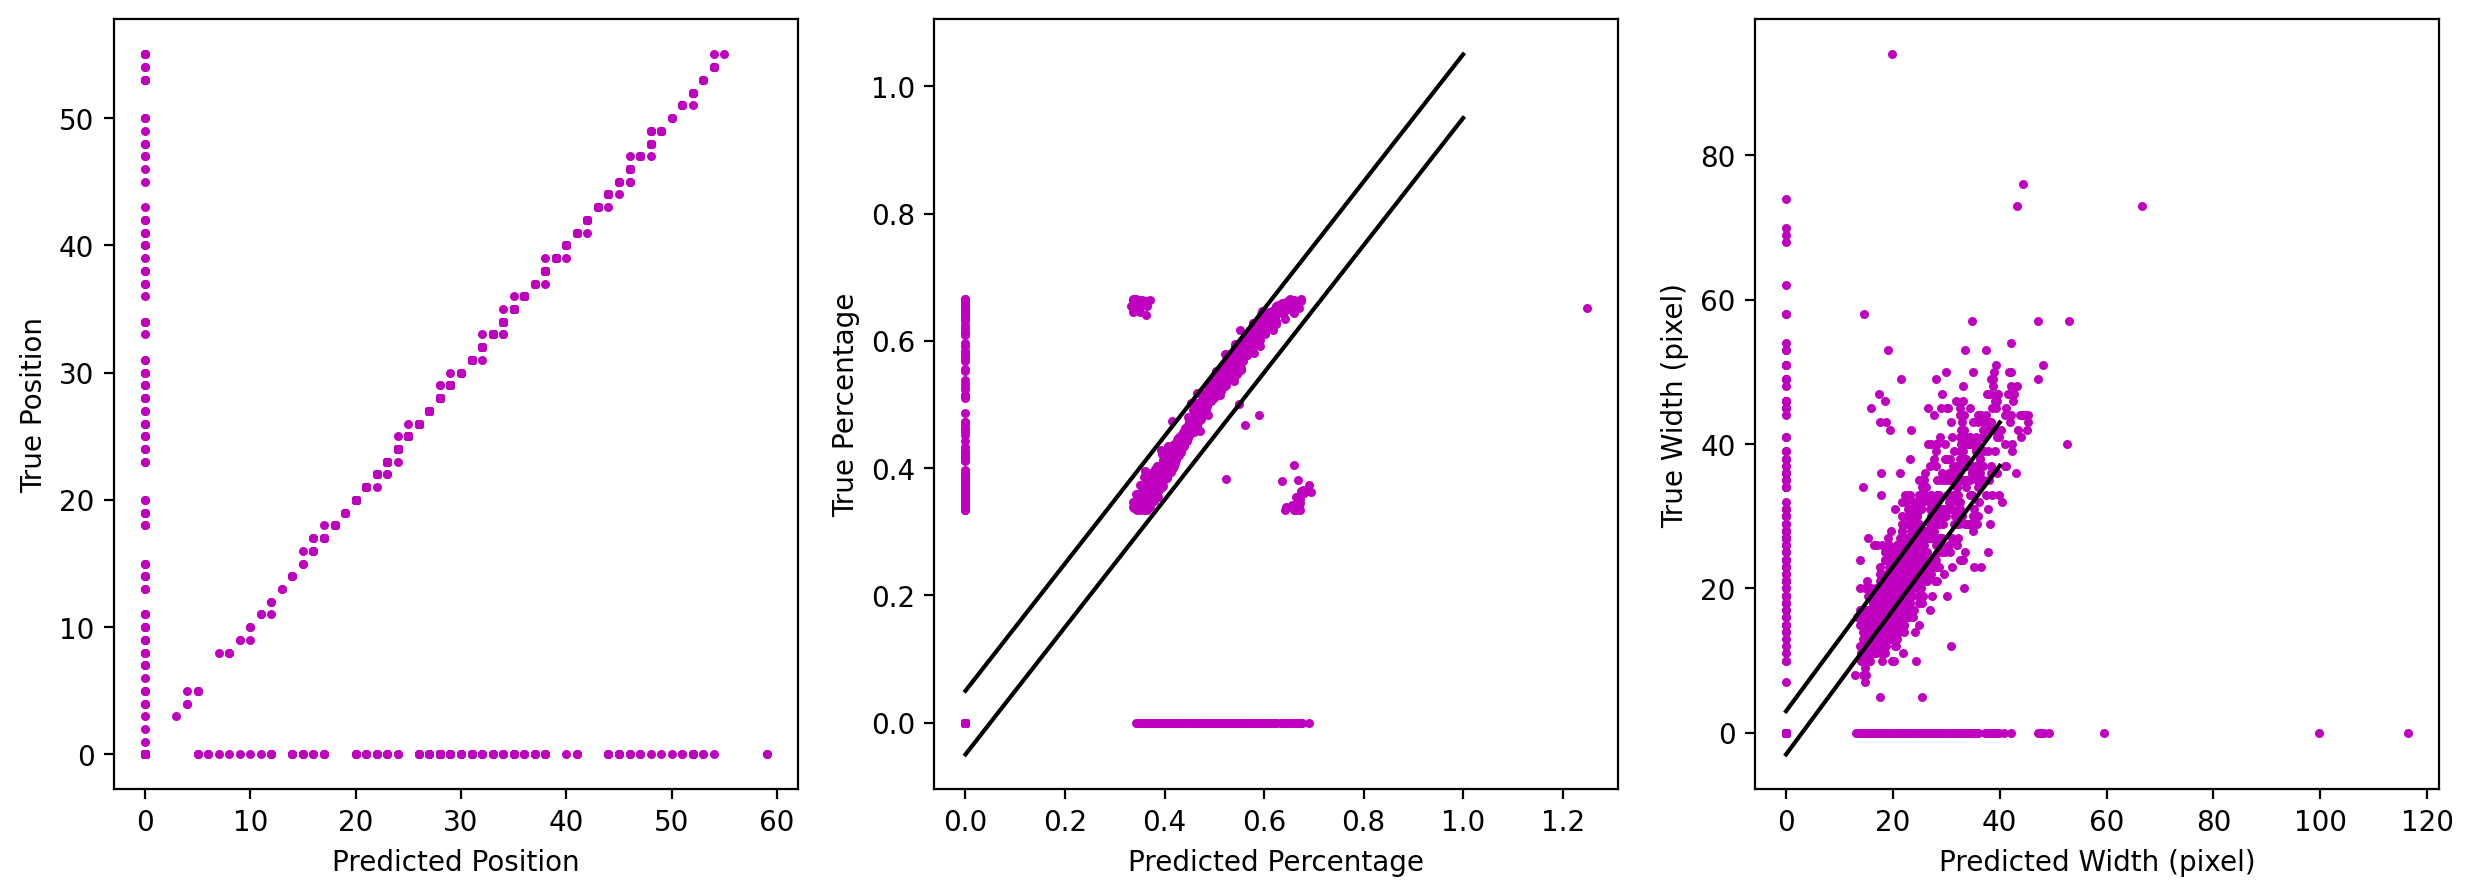

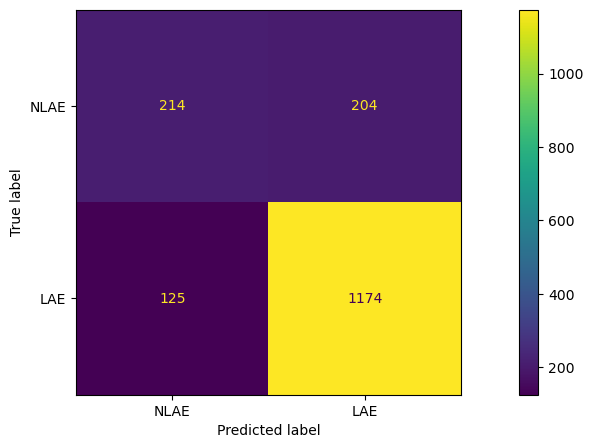

In [49]:
output, label, diff = test_perform(model = model, spectra = test_iron_spetra, label = test_iron_label, info_spectra = info_spectra, plot_wrong = False)

In [ ]:
def check_LAE(model):
  with torch.no_grad():
    data = torch.tensor(LAE_flux_test).to(device).float()
    model = model.to(device).float()
    output, x_scale_1, x1_1, x1_2, x1_3, x1_4, x1_5, x1_6, x1_7, x_cropped, x_scale_2, x_scale_3, x3_1, x3_2, x_cropped2 = model(data)
  return x_cropped2

In [ ]:
def optimal_perform(search_space):
    n = 0
    while True:
        n += 1
        print("=======================================================================================================================")
        print(f"No.{n} trial:")
        model, train_loss, test_loss, test_acc_1, test_acc_2, test_acc_3, output1_record_train, output2_record_train, output3_record_train, output1_record_test, output2_record_test, output3_record_test = build_model(config = search_space, ray_tune = False)

In [ ]:
search_space = {
    "lr": 0.009,
    "kernel_size1_1": 21,
    "kernel_size1_4": 3,
    "kernel_size3_1": 21,
    "kernel_size3_2": 5,
    "kernel_size4_1": 3,
    "kernel_size4_2": 3,
    "batch_size": 64,
    "ratio": 1.9,
    "out_channel7": 100,
    "pooling": 3,
    "loss_weight_1": 100,
    "loss_weight_2": 1,
    "loss_weight_3": 10,
    "fc_width1": 256,
    "fc_width2": 256,
    "fc_width3": 256,
    "rescale_1": "mean",
    "rescale_2": "mean",
    "rescale_3": "mean",
    "LAE_weight": 5
    # "momentum": tune.grid_search([1.1]),
    # "weight_decay": tune.grid_search([0])
}

optimal_perform(search_space)

In [ ]:
search_space = {
    "lr": tune.grid_search([0.006]),
    "kernel_size1_1": tune.grid_search([21]),
    "kernel_size1_4": tune.grid_search([3]),
    "kernel_size3_1": tune.grid_search([21]),
    "kernel_size3_2": tune.grid_search([5]),
    "kernel_size4_1": tune.grid_search([3]),
    "kernel_size4_2": tune.grid_search([3]),
    "batch_size": tune.grid_search([256]),
    "ratio": tune.grid_search([1.9]),
    "out_channel7": tune.grid_search([100]),
    "pooling": tune.grid_search([3]),
    "loss_weight_1": tune.grid_search([100]),
    "loss_weight_2": tune.grid_search([1]),
    "loss_weight_3": tune.grid_search([10]),
    "fc_width1": tune.grid_search([256]),
    "fc_width2": tune.grid_search([256]),
    "fc_width3": tune.grid_search([256]),
    "rescale_1": tune.grid_search(["mean"]),
    "rescale_2": tune.grid_search(["mean"]),
    "rescale_3": tune.grid_search(["mean"]),
    "LAE_weight": tune.grid_search([2,3,4,5,6,7,8,9,10])
    # "momentum": tune.grid_search([1.1]),
    # "weight_decay": tune.grid_search([0])
}

# parser = argparse.ArgumentParser(description = "DESSI_LAE")
# parser.add_argument(
#     "--cuda", action = "store_true", default = False, help = "Enables GPU training"
# )

# args, _ = parser.parse_known_args()

# ray.init(ignore_reinit_error = True)

# sched = AsyncHyperBandScheduler()

# resources_per_trial = {"gpu": 1}  # set this for GPUs
# tuner = tune.Tuner(
#     tune.with_resources(build_model, resources = resources_per_trial),
#     tune_config = tune.TuneConfig(
#         metric = "mean_accuracy",
#         mode = "max",
#         scheduler = sched,
#         num_samples = 5,
#     ),
#     param_space = search_space
# )
    
# results = tuner.fit()

trainable_with_gpu = tune.with_resources(build_model, {"gpu": 4})
tuner = tune.Tuner(
    trainable_with_gpu,
    param_space = search_space,
    tune_config = tune.TuneConfig(num_samples = 5)
)
results = tuner.fit()

# tuner = tune.Tuner(build_model, param_space = search_space, tune_config = tune.TuneConfig(num_samples = 5, scheduler = sched))
# results = tuner.fit()

# analysis = tune.run(build_model, config = search_space)

In [ ]:
model = torch.load(f"../DESI_LAE_model/model_0.979_0.979_0.881_2024-02-07 07:13:17.397448.pt")
output, refer, diff = test_metrics(model, plot_wrong = True)

In [ ]:
plot_loss_iter(test_loss = [i.item() for i in test_loss], train_loss = [i.item() for i in train_loss])

In [ ]:
plot_test_accuracy(test_acc1 = test_acc_1, test_acc2 = test_acc_2, test_acc3 = test_acc_3)

In [ ]:
for i in range(0, len(output1_record_train) - 1):
  plt.close()
  plt.figure(figsize = (16, 5))
  plot_scatter(x = output1_record_train[i][1].to("cpu"), y = output1_record_train[i][0].to("cpu"), c = "m", ylabel = "Predicted Position", xlabel = "True Position", position = 1)
  plot_scatter(x = output2_record_train[i][1].to("cpu"), y = output2_record_train[i][0].to("cpu"), c = "m", ylabel = "Predicted Percentage", xlabel = "True Percentage", position = 2)
  plot_scatter(x = output3_record_train[i][1].to("cpu"), y = output3_record_train[i][0].to("cpu"), c = "m", ylabel = "Predicted FWHM", xlabel = "True FWHM", position = 3)

  plot_scatter(x = output1_record_test[i][1].to("cpu"), y = output1_record_test[i][0].to("cpu"), c = "y", ylabel = "Predicted Position", xlabel = "True Position", position = 1)
  plot_scatter(x = output2_record_test[i][1].to("cpu"), y = output2_record_test[i][0].to("cpu"), c = "y", ylabel = "Predicted Percentage", xlabel = "True Percentage", position = 2)
  plot_scatter(x = output3_record_test[i][1].to("cpu"), y = output3_record_test[i][0].to("cpu"), c = "y", ylabel = "Predicted FWHM", xlabel = "True FWHM", position = 3)
  plt.show()

In [ ]:
a[c]

In [ ]:
b[c]

In [ ]:
x_cropped2 = check_LAE(model = model)

In [ ]:
for i in x_cropped2:
  plt.close()
  plt.plot(i[0].to("cpu"))
  plt.show()

In [ ]:
spectra_train, spectra_test = train_test_split(LAE_spectra, test_size = 0.2, random_state = 2)
x_range = np.linspace(0, 2438, x_cropped2.shape[-1])
for i in range(0, x_cropped2.shape[0]):
  plt.close()
  plt.rcParams['figure.figsize'] = [16, 4]
  plt.plot(x_range, x_scale_1[i][0].to("cpu"), c = "k", lw = 1)
  plt.plot(spectra_test[i]["flux"], alpha = 0.5, c = "r", lw = 1)
  plt.title(spectra_test[i]['specid'])
  plt.savefig("/content/drive/MyDrive/CNN/result/x_scale_1/" + str(spectra_test[i]['specid']) + ".jpg")
  plt.show()

In [ ]:
x_range = np.linspace(0, len(x_cropped[0][0]), x_scale_3.shape[-1])
for i in range(0, x_scale_3.shape[0]):
  plt.close()
  plt.rcParams['figure.figsize'] = [16, 4]
  # plt.plot(x_range, x_cropped[i][0].to("cpu"), c = "k", lw = 1, alpha = 0.5)
  # plt.plot(x_range, x_cropped[i][1].to("cpu"), c = "r", lw = 1, alpha = 0.5)
  plt.plot(x_range, x_scale_2[i][0].to("cpu"), c = "k", lw = 1)
  plt.plot(x_range, x_scale_2[i][1].to("cpu"), c = "r", lw = 1)
  plt.title(spectra_test[i]['specid'])
  plt.savefig("/content/drive/MyDrive/CNN/result/x_scale_3/" + str(spectra_test[i]['specid']) + ".jpg")
  plt.show()